# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
# but don't close it right now, https://github.com/Unity-Technologies/ml-agents/issues/1167
# env.close() 

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

***
***
#### 1. Load agent and set up environment
Following the Deep Q-Network (DQN) exercise structure, the agent class is defined in dqn_agent.py script. 
The agent class uses the QNetwork defined in model.py.  

Then open the environment and get the default brain

In [7]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# how does it perform without training?
# reset environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

# run without training
score = []
for j in range(100):
    # select action
    action = agent.act(state).astype(int)
    env_info = env.step(action)[brain_name]
    
    # get the next state
    state = env_info.vector_observations[0]
    # get the reward
    reward = env_info.rewards[0]
    score.append(reward)
    # see if episode has finished
    done = env_info.local_done[0]
    if done:
        break
    print("\rCumulative score: {}, step: {}".format(np.sum(score), j), end="")

Cumulative score: 2.0, step: 99

#### 2. Train agent
Inspired in the Deep Q-Network (DQN) exercise structure again, train the agent and plot the results

In [8]:
# import the necessary libraries
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Episode 100	Average Score: 1.24
Episode 200	Average Score: 5.06
Episode 300	Average Score: 7.78
Episode 400	Average Score: 10.03
Episode 500	Average Score: 12.27
Episode 537	Average Score: 13.00
Environment solved in 437 episodes!	Average Score: 13.00


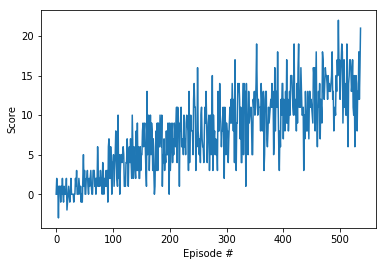

In [9]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, success_score=+13.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        success_score: agent must get an average score of success_score over 100 consecutive episodes to consider solved
    """
    scores = []                                                    # list containing scores from each episode
    scores_window = deque([0.0 for _ in range(100)], maxlen=100)   # last 100 scores
    eps = eps_start                                                # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        state = env_info.vector_observations[0]                # get the current state
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)          # send the action to the environment
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]        # get the next state
            reward = env_info.rewards[0]                        # get the reward
            done = env_info.local_done[0]                       # see if episode has finished

            agent.step(state, action, reward, next_state, done) # agent steps
            state = next_state                                  # update state
            score += reward                                     # update reward

            if done:
                break                                           # start next episode if this one finished
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=success_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
            break
        
    return scores

#env_info = env.reset(train_mode=False)[brain_name]
scores = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 3. Evaluate trained agent
In the next code cell, load the trained weights from file to see a smart agent results over some episodes!

In [10]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('model.pt'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]              # get the next state
    # run trained model
    score = []
    for j in range(100):
        # select action
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]

        # get the next state
        state = env_info.vector_observations[0]
        # get the reward
        reward = env_info.rewards[0]
        score.append(reward)
        # see if episode has finished
        done = env_info.local_done[0]
        if done:
            break
        print("\rCumulative score: {}, step: {}".format(np.sum(score), j), end="")
    print()

Cumulative score: 6.0, step: 99
Cumulative score: 6.0, step: 99
Cumulative score: 5.0, step: 99
Cumulative score: 5.0, step: 99
Cumulative score: 9.0, step: 99


In [11]:
# now it's ok to close the environment
env.close() 